In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('crime_dataset_india[1].csv')
df.head()
df.shape

(40160, 14)

In [ ]:

df = df.drop_duplicates()

df.replace([np.inf, -np.inf], np.nan, inplace=True)

cols_to_keep_na = ['Case Closed', 'Date Case Closed']
df = df.dropna(subset=[col for col in df.columns if col not in cols_to_keep_na])

numeric_cols = df.select_dtypes(include=['number']).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape


(34370, 14)

In [ ]:
import pandas as pd

city_to_state = {
    'Ahmedabad': 'Gujarat',
    'Chennai': 'Tamil Nadu',
    'Ludhiana': 'Punjab',
    'Pune': 'Maharashtra',
    'Delhi': 'Delhi',
    'Mumbai': 'Maharashtra',
    'Surat': 'Gujarat',
    'Visakhapatnam': 'Andhra Pradesh',
    'Kolkata': 'West Bengal',
    'Ghaziabad': 'Uttar Pradesh',
    'Bangalore': 'Karnataka',
    'Hyderabad': 'Telangana',
    'Jaipur': 'Rajasthan',
    'Bhopal': 'Madhya Pradesh',
    'Patna': 'Bihar',
    'Kanpur': 'Uttar Pradesh',
    'Lucknow': 'Uttar Pradesh',
    'Varanasi': 'Uttar Pradesh',
    'Nagpur': 'Maharashtra',
    'Thane': 'Maharashtra',
    'Indore': 'Madhya Pradesh',
    'Rajkot': 'Gujarat',
    'Vasai': 'Maharashtra',
    'Agra': 'Uttar Pradesh',
    'Meerut': 'Uttar Pradesh',
    'Kalyan': 'Maharashtra',
    'Nashik': 'Maharashtra',
    'Srinagar': 'Jammu and Kashmir',
    'Faridabad': 'Haryana'
}


df['State'] = df['City'].map(city_to_state)



In [ ]:
import plotly.express as px

crime_counts = df['State'].value_counts().reset_index()
crime_counts.columns = ['State', 'Crime Count']


fig = px.choropleth(
    crime_counts,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='State',
    color='Crime Count',
    color_continuous_scale=['lightgreen', 'darkgreen'],
    title='Crime Count by State in India',
    scope='asia'
)

fig.update_geos(fitbounds="locations", visible=False,
    landcolor="lightgray",
    showcoastlines=True,
    coastlinecolor="black",
    showland=True,
    showocean=True,
    showcountries=True,
    countrycolor="Black",
    oceancolor="lightblue"
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

**This choropleth map visualizes crime distribution across different states in India, with color intensity representing crime counts. Darker shades of green indicate states with higher crime rates, making it easy to compare crime levels geographically. The map provides a clear spatial understanding of crime concentration across the country.**

In [ ]:
import plotly.express as px

if 'Victim Age' in df.columns and 'City' in df.columns:

    df_under_18 = df[df['Victim Age'] < 18]
    city_counts = df_under_18.groupby('City')['Victim Age'].count().reset_index(name='Case Count')
    city_counts = city_counts.sort_values('Case Count', ascending=False)
    fig = px.bar(city_counts, x='City', y='Case Count', title='Cities with Most Cases for Victims Under 18',
                 labels={'City': 'City', 'Case Count': 'Number of Cases'},
                 color='Case Count')
    fig.update_layout(xaxis_title='City', yaxis_title='Number of Cases')
    fig.show()


**This bar chart visualizes the number of cases involving victims under 18, grouped by city. It displays cities with the highest case counts in descending order, with color intensity reflecting the number of cases**

<ipython-input-6-8ea57a8e338a>:5: UserWarning:

Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



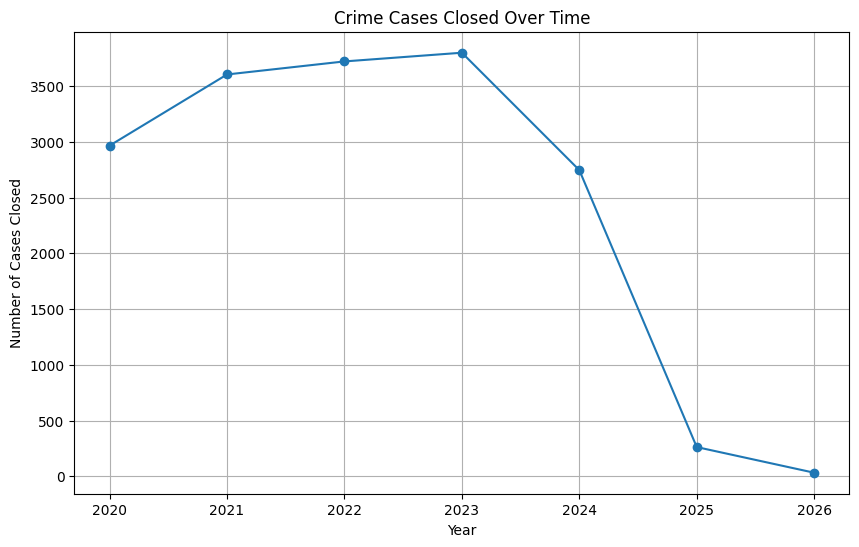

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

if 'Date Case Closed' in df.columns:
    df['Date Case Closed'] = pd.to_datetime(df['Date Case Closed'], errors='coerce')


df_line_chart = df.groupby(df['Date Case Closed'].dt.year).size()


plt.figure(figsize=(10, 6))
plt.plot(df_line_chart.index, df_line_chart.values, marker='o', linestyle='-')


plt.xlabel("Year")
plt.ylabel("Number of Cases Closed")
plt.title("Crime Cases Closed Over Time")
plt.grid(True)


plt.show()


**This line chart shows the trend of crime cases closed over time, with the x-axis representing the years and the y-axis indicating the number of cases closed. The data is grouped by year based on the "Date Case Closed" column. The chart provides insights into how the number of closed cases has varied across different years.**

In [ ]:
import pandas as pd
import plotly.express as px

if 'State' in df.columns and 'Crime Description' in df.columns:

    df_sunburst = df.groupby(['State', 'Crime Description']).size().reset_index(name='Crime Count')

    fig = px.sunburst(
        df_sunburst,
        path=['State', 'Crime Description'],
        values='Crime Count',
        color='Crime Count',
        color_continuous_scale='RdYlBu',
        title="Crime Distribution by State and Type"
    )

    fig.show()


**This sunburst chart visualizes the distribution of crimes by state and type, with the hierarchy structured from state to specific crime types. The chart shows how crime counts are distributed across different states and crime categories. The color gradient represents the number of crimes, helping to highlight areas with higher crime rates**

In [ ]:
if 'Time Hour' in df.columns and 'Crime Description' in df.columns:
    top_states = df['Time Hour'].value_counts().nlargest(5).index.tolist()
    df_top_states = df[df['Time Hour'].isin(top_states)]
    crime_counts = df_top_states.groupby(['Time Hour', 'Crime Description']).size().unstack(fill_value=0)
    fig = go.Figure()

    for state in top_states:
      fig.add_trace(go.Scatter(
          x=crime_counts.columns,
          y=crime_counts.loc[state],
          mode='lines+markers',
          name=state
      ))

    fig.update_layout(
        title="Crimes happened different time hours - Slope Chart",
        xaxis_title="Crime Description",
        yaxis_title="Number of Crimes",
    )
    fig.show()


**This slope chart compares the distribution of crimes across different crime descriptions for the top 5 hours of the day in the dataset. Each line represents a specific hour, showing how the number of crimes for different crime types varies over time. The chart allows for easy comparison of crime patterns at specific times across different states**.

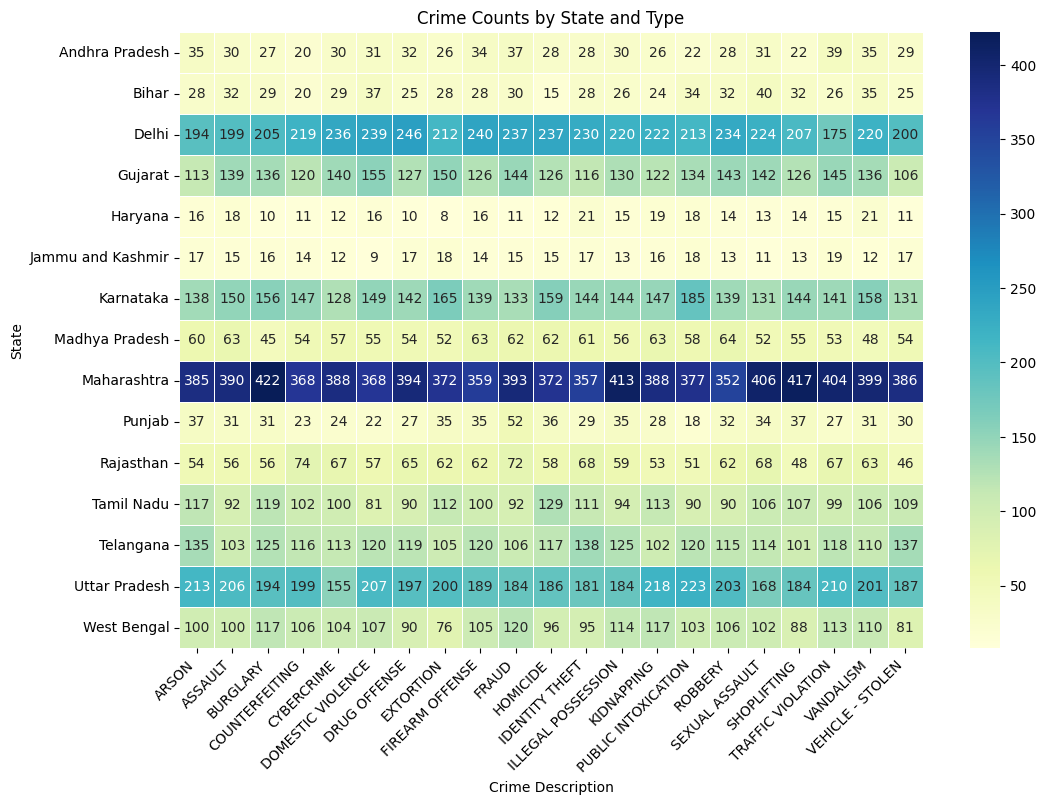

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if 'State' in df.columns and 'Crime Description' in df.columns:
    crime_counts = df.groupby(['State', 'Crime Description']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(crime_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.title("Crime Counts by State and Type")
    plt.xlabel("Crime Description")
    plt.ylabel("State")
    plt.xticks(rotation=45, ha='right')
    plt.show()


**This heatmap shows crime counts by state and type, with color intensity indicating the number of crimes. States are on the y-axis, and crime types are on the x-axis. Annotations display the exact crime count for each state-crime combinatio**

In [ ]:
import pandas as pd
import plotly.graph_objects as go


if 'State' in df.columns and 'Crime Description' in df.columns:
    top_states = df['State'].value_counts().nlargest(2).index.tolist()
    df_top_states = df[df['State'].isin(top_states)]
    crime_counts = df_top_states.groupby(['State', 'Crime Description']).size().unstack(fill_value=0)
    categories = list(crime_counts.columns)
    fig = go.Figure()

    for state in top_states:
        fig.add_trace(go.Scatterpolar(
            r=crime_counts.loc[state].values.tolist(),
            theta=categories,
            fill='toself',
            name=state
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, crime_counts.max().max() * 1.2]
            )),
        title="Crime Distribution Comparison (Top 2 States)",
        showlegend=True
    )
    fig.show()

**This radar chart compares crime distributions across the top two states with the highest crime counts. Each axis represents a different crime type, and the chart shows how crime patterns vary between the states. The filled areas help visualize the intensity of different crime types in each state.**

<Figure size 1200x600 with 0 Axes>

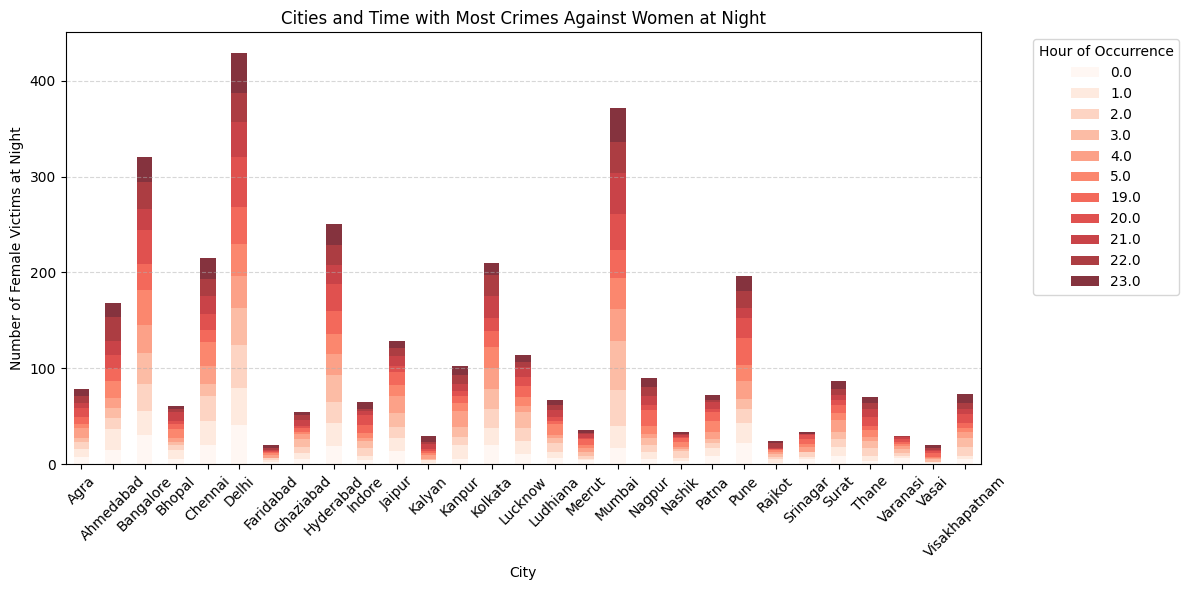

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df['Time Hour'] = pd.to_datetime(df['Time of Occurrence'], errors='coerce').dt.hour
night_hours = list(range(19, 24)) + list(range(0, 6))
df_night_female = df[(df['Victim Gender'] == 'F') & (df['Time Hour'].isin(night_hours))]

city_time_counts = df_night_female.groupby(['City', 'Time Hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
city_time_counts.plot(kind='bar', stacked=True, colormap='Reds', alpha=0.8, figsize=(12, 6))

plt.xlabel("City")
plt.ylabel("Number of Female Victims at Night")
plt.title("Cities and Time with Most Crimes Against Women at Night")
plt.xticks(rotation=45)
plt.legend(title="Hour of Occurrence", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**This stacked bar chart visualizes crimes against female victims occurring at night (7 PM to 6 AM) across different cities. Each bar represents a city, with segments showing the distribution of crimes by specific night-time hours. The chart helps identify high-risk cities and peak hours for such incidents.**

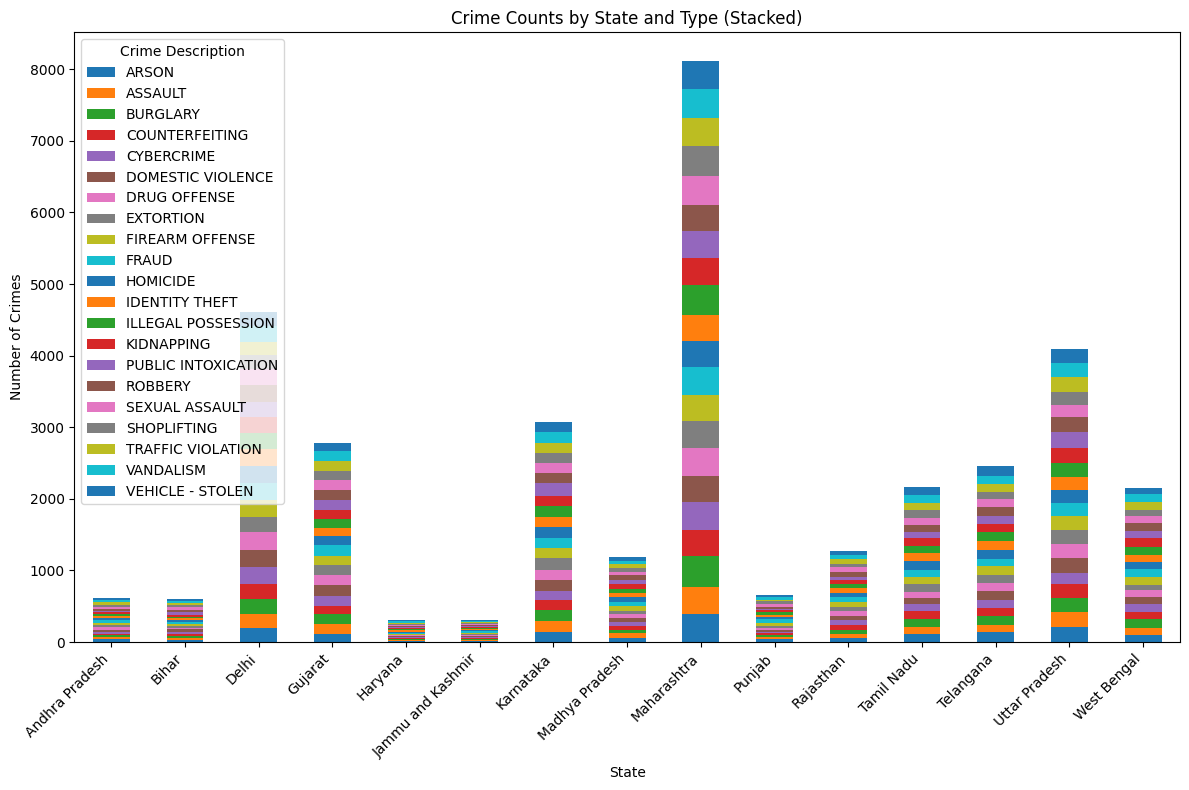

In [ ]:
import matplotlib.pyplot as plt

if 'State' in df.columns and 'Crime Description' in df.columns:
    crime_counts = df.groupby(['State', 'Crime Description']).size().unstack(fill_value=0)
    crime_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Crime Counts by State and Type (Stacked)')
    plt.xlabel('State')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Crime Description')
    plt.tight_layout()
    plt.show()

**This stacked bar chart displays the distribution of different crime types across various states. Each bar represents a state, with segments indicating the number of crimes for each type. The chart helps compare crime patterns among states and identify those with the highest crime rates.**











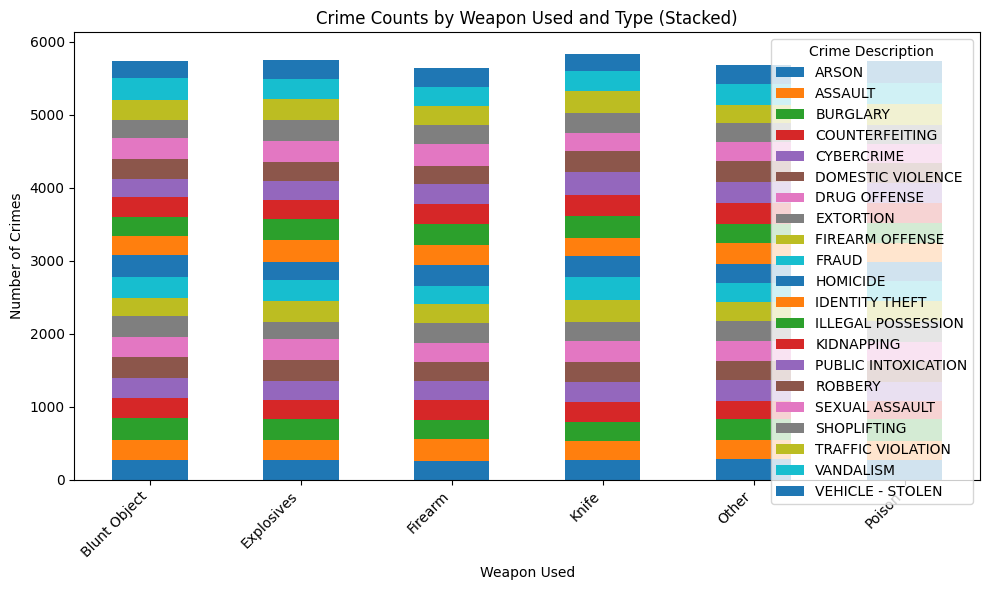

In [ ]:
if 'Weapon Used' in df.columns and 'Crime Description' in df.columns:
    crime_counts = df.groupby(['Weapon Used', 'Crime Description']).size().unstack(fill_value=0)
    crime_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Crime Counts by Weapon Used and Type (Stacked)')
    plt.xlabel('Weapon Used')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Crime Description')
    plt.tight_layout()
    plt.show()

**This stacked bar chart visualizes the relationship between weapons used and different crime types. Each bar represents a weapon category, with segments showing the distribution of crime types associated with it. The chart helps identify which weapons are most commonly used in various crimes**

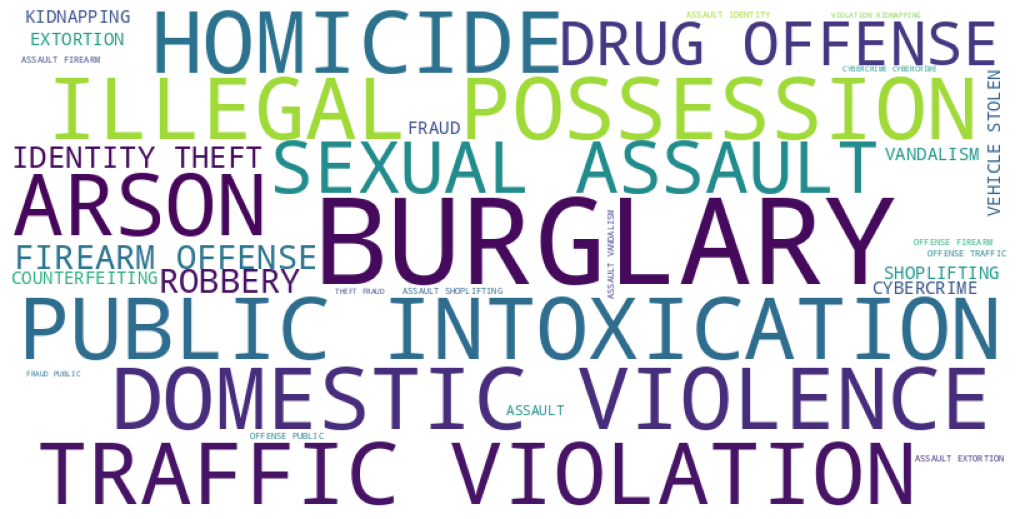

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

if 'Crime Description' in df.columns:
    text = " ".join(df['Crime Description'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

**This word cloud visualizes the most frequent crime descriptions by displaying commonly occurring words in larger fonts. It helps identify prevalent crime types at a glance based on textual data. The visualization highlights key crime patterns and trends in a simple, engaging format.**

In [ ]:
import pandas as pd
import plotly.express as px

df_case_counts = df.groupby(['City', 'Case Closed']).size().reset_index(name='Count')
fig = px.treemap(df_case_counts, path=['City', 'Case Closed'], values='Count',
                 title="Treemap of Case Closure Status by City",
                 color='Count', color_continuous_scale='Blues')
fig.show()

**The treemap shows the distribution of case closure statuses across cities, with each city's cases grouped hierarchically. The size of each block represents the number of cases, making comparisons easier. Darker shades indicate higher case counts, highlighting trends across locations.**

# **Machine learning algorithms implementation ideas for 2nd review**

**1. Crime Hotspot Prediction
Goal: Predict which locations (cities) are most likely to have crimes at a given time.
ML Techniques: Clustering (K-Means, DBSCAN) to identify high-crime zones, time-series forecasting (LSTM, ARIMA).
Outcome: A model that helps authorities deploy resources to high-risk areas at specific times.**

**2. Safety Index for Women at Night
Goal: Develop a safety index that ranks cities based on crime rates against women at night.
ML Techniques: Weighted scoring system, clustering, anomaly detection.
Outcome: A public dashboard that informs women about the safest and riskiest cities at night**

In [ ]:
#df.to_csv('/content/data.csv', index=False)  # Save CSV in Colab's environment
#from google.colab import files
#files.download('/content/data.csv')

In [ ]:
city_data = df.groupby('City').size().reset_index(name='City Count')
city_data


,City,City Count
0,Agra,644
1,Ahmedabad,1557
2,Bangalore,3070
3,Bhopal,587
4,Chennai,2159
5,Delhi,4609
6,Faridabad,301
7,Ghaziabad,595
8,Hyderabad,2459
9,Indore,604


In [ ]:
#saftey score using random forest regressor

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df['Crime Severity'] = 1
crime_features = df.groupby('City').agg({'Crime Severity': ['sum', 'count'], 'Police Deployed': 'sum'})
crime_features.columns = ['Total Crime Severity', 'Crime Count', 'Total Police Deployed']


crime_features['Safety Score'] = (
    (crime_features['Crime Count'].max() - crime_features['Crime Count']) /
    (crime_features['Crime Count'].max() - crime_features['Crime Count'].min()) * 0.5 +
    (crime_features['Total Crime Severity'].max() - crime_features['Total Crime Severity']) /
    (crime_features['Total Crime Severity'].max() - crime_features['Total Crime Severity'].min()) * 0.5
)

X = crime_features[['Total Crime Severity', 'Crime Count', 'Total Police Deployed']]
y = crime_features['Safety Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
crime_features['Predicted Safety Score'] = model.predict(X)
top_5_cities = crime_features[['Predicted Safety Score']].nlargest(5, 'Predicted Safety Score')
print(f"Model R² Score: {r2:.3f}")
print(f"Model RMSE: {rmse:.3f}")
print("\nTop 5 Cities with Highest Safety Scores:")
print(top_5_cities)


Model R² Score: 0.976
Model RMSE: 0.028

Top 5 Cities with Highest Safety Scores:
           Predicted Safety Score
City                             
Faridabad                0.992794
Rajkot                   0.992720
Kalyan                   0.992295
Varanasi                 0.992125
Nashik                   0.990962


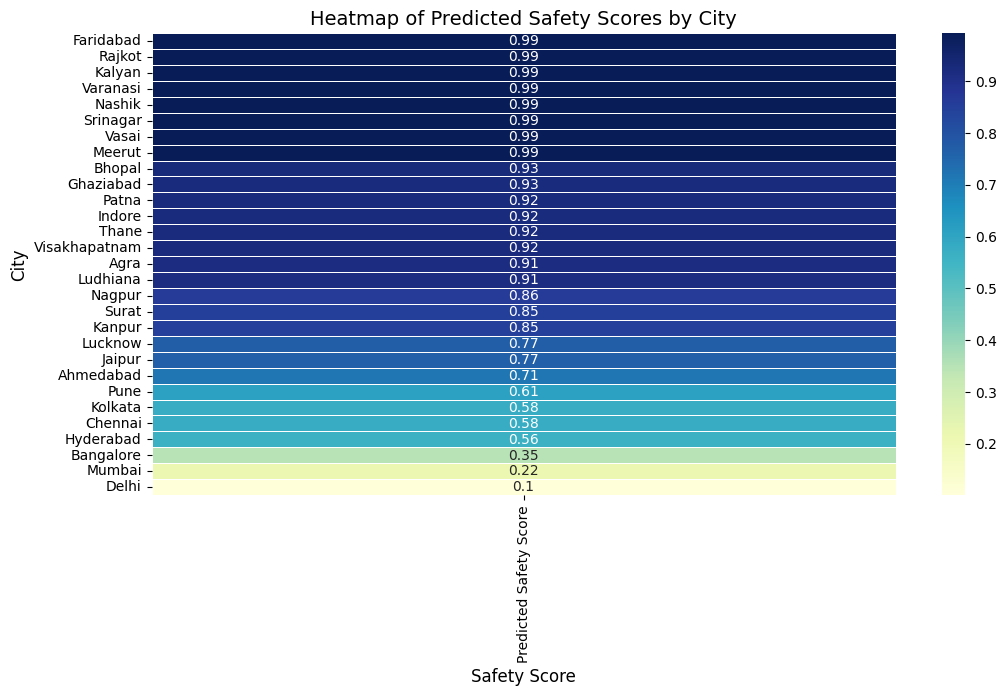

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df['Crime Severity'] = 1
crime_features = df.groupby('City').agg({'Crime Severity': ['sum', 'count'], 'Police Deployed': 'sum'})
crime_features.columns = ['Total Crime Severity', 'Crime Count', 'Total Police Deployed']

crime_features['Safety Score'] = (
    (crime_features['Crime Count'].max() - crime_features['Crime Count']) /
    (crime_features['Crime Count'].max() - crime_features['Crime Count'].min()) * 0.5 +
    (crime_features['Total Crime Severity'].max() - crime_features['Total Crime Severity']) /
    (crime_features['Total Crime Severity'].max() - crime_features['Total Crime Severity'].min()) * 0.5
)

X = crime_features[['Total Crime Severity', 'Crime Count', 'Total Police Deployed']]  # Features
y = crime_features['Safety Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

crime_features['Predicted Safety Score'] = model.predict(X)
top_5_cities = crime_features[['Predicted Safety Score']].nlargest(5, 'Predicted Safety Score')

crime_features_sorted = crime_features.sort_values(by='Predicted Safety Score', ascending=False)
plt.figure(figsize=(12, 6))
sns.heatmap(crime_features_sorted[['Predicted Safety Score']], cmap='YlGnBu', annot=True, linewidths=0.5)

plt.title("Heatmap of Predicted Safety Scores by City", fontsize=14)
plt.xlabel("Safety Score", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:

import pandas as pd
import plotly.express as px
crime_counts = df['State'].value_counts().reset_index()
crime_counts.columns = ['State', 'Crime Count']

fig = px.choropleth(
    crime_counts,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='State',
    color='Crime Count',
    color_continuous_scale=['lightgreen', 'red'],
    title='Crime Count by State in India',
    scope='asia'
)

fig.update_geos(fitbounds="locations", visible=False,
    landcolor="lightgray",
    showcoastlines=True,
    coastlinecolor="black",
    showland=True,
    showocean=True,
    showcountries=True,
    countrycolor="Black",
    oceancolor="lightblue"
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()


In [ ]:
#most common crime by random forest classifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

df = pd.read_csv('crime_dataset_india[1].csv')
df['Time Hour'] = pd.to_datetime(df['Time of Occurrence'], errors='coerce').dt.hour
if 'Crime Severity' not in df.columns:
    df['Crime Severity'] = 1

df = df[['City', 'Crime Description', 'Time Hour', 'Crime Severity']].dropna()
df = df.rename(columns={'Crime Description': 'Crime Type', 'Time Hour': 'Time'})
label_encoders = {}
for col in ['City', 'Time']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])
label_encoders['Crime Type'] = LabelEncoder()
df['Crime Type'] = label_encoders['Crime Type'].fit_transform(df['Crime Type'])


X = df[['City', 'Time', 'Crime Severity']]
y = df['Crime Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
predicted_crimes = label_encoders['Crime Type'].inverse_transform(y_pred)

df_test = X_test.copy()
df_test['Predicted Crime Type'] = predicted_crimes
df_test['City'] = label_encoders['City'].inverse_transform(df_test['City'])
common_crime_by_city = df_test.groupby('City')['Predicted Crime Type'].agg(lambda x: x.value_counts().idxmax())
print("\nMost Common Crime Type by City:")
print(common_crime_by_city)


Most Common Crime Type by City:
City
Agra             PUBLIC INTOXICATION
Ahmedabad             SEXUAL ASSAULT
Bangalore                   BURGLARY
Bhopal                         ARSON
Chennai                 DRUG OFFENSE
Delhi                 IDENTITY THEFT
Faridabad                   BURGLARY
Ghaziabad             IDENTITY THEFT
Hyderabad           VEHICLE - STOLEN
Indore             DOMESTIC VIOLENCE
Jaipur                    KIDNAPPING
Kalyan             TRAFFIC VIOLATION
Kanpur                         FRAUD
Kolkata                        FRAUD
Lucknow                    VANDALISM
Ludhiana                    HOMICIDE
Meerut                       ROBBERY
Mumbai                   SHOPLIFTING
Nagpur                     EXTORTION
Nashik                       ASSAULT
Patna                 IDENTITY THEFT
Pune                 FIREARM OFFENSE
Rajkot                    KIDNAPPING
Srinagar                       FRAUD
Surat                      VANDALISM
Thane                     CYBERCRIME


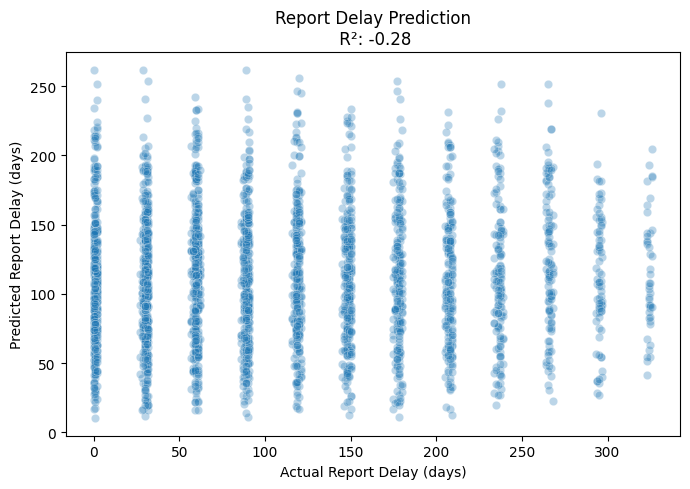

R² Score: -0.28


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce')
df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce')
df['Report_Delay_Days'] = (df['Date Reported'] - df['Date of Occurrence']).dt.days

df = df[(df['Report_Delay_Days'].notna()) & (df['Report_Delay_Days'] >= 0)]
df['Victim_Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Is_Female_Victim'] = (df['Victim Gender'] == 'F').astype(int)
features = ['Victim_Age', 'Is_Female_Victim', 'Police Deployed']
df = df.dropna(subset=features + ['Report_Delay_Days'])
X = df[features]
y = df['Report_Delay_Days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual Report Delay (days)")
plt.ylabel("Predicted Report Delay (days)")
plt.title(f"Report Delay Prediction\n R²: {r2:.2f}")
plt.tight_layout()
plt.show()
print(f"R² Score: {r2:.2f}")


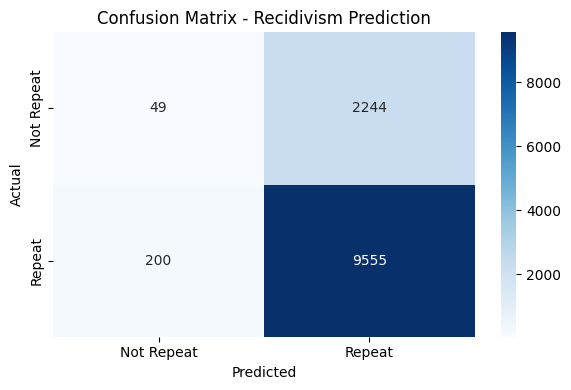

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.02      0.04      2293
           1       0.81      0.98      0.89      9755

    accuracy                           0.80     12048
   macro avg       0.50      0.50      0.46     12048
weighted avg       0.69      0.80      0.73     12048



In [ ]:
#using random forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("crime_dataset_india[1].csv")
np.random.seed(42)
num_unique_offenders = int(len(df) * 0.6)
offender_ids = np.random.choice(range(1000, 1000 + num_unique_offenders), size=len(df), replace=True)
df['Offender_ID'] = offender_ids

df['Repeat_Offender'] = df.duplicated(subset='Offender_ID', keep=False).astype(int)
df['First_Time_Offense'] = ~df.duplicated(subset='Offender_ID', keep='first')
df['First_Time_Offense'] = df['First_Time_Offense'].astype(int)
df['Victim_Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Is_Female_Victim'] = (df['Victim Gender'] == 'F').astype(int)

features = ['Victim_Age', 'Is_Female_Victim', 'Police Deployed']
df = df.dropna(subset=features + ['Repeat_Offender'])

X = df[features]
y = df['Repeat_Offender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Repeat', 'Repeat'],
            yticklabels=['Not Repeat', 'Repeat'])
plt.title("Confusion Matrix - Recidivism Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
print("Classification Report:")
print(report)

In the heatmap confusion matrix

Top-left (TN): Model correctly predicted someone is not a repeat offender.

Bottom-right (TP): Model correctly predicted someone is a repeat offender.

Top-right (FP): Model wrongly predicted someone is a repeat offender.

Bottom-left (FN): Model wrongly predicted someone is not a repeat offender.

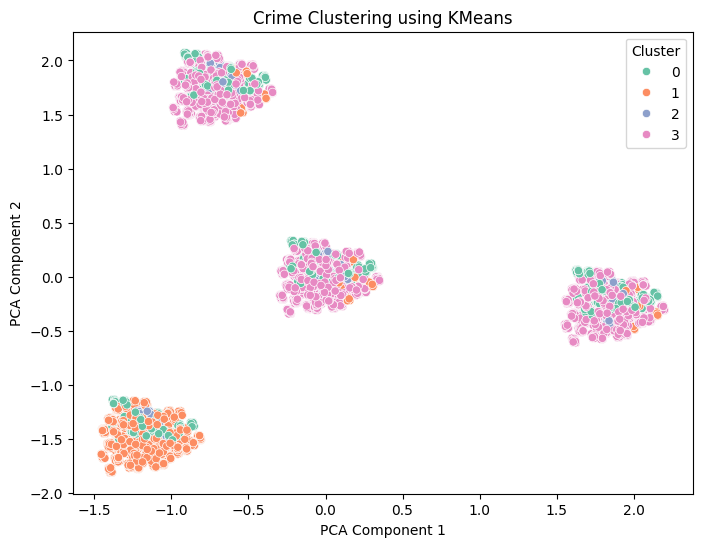

     Crime_Description   Weapon_Used Time_of_Day  Victim_Age  \
0       IDENTITY THEFT  Blunt Object       Night          16   
1             HOMICIDE        Poison       Night          37   
2           KIDNAPPING  Blunt Object       Night          48   
3             BURGLARY       Firearm       Night          49   
4            VANDALISM         Other       Night          30   
5              ASSAULT       Firearm       Night          16   
6     VEHICLE - STOLEN         Knife     Morning          64   
7       COUNTERFEITING         Knife     Morning          78   
8            EXTORTION  Blunt Object     Morning          41   
9  PUBLIC INTOXICATION         Knife     Morning          29   

   Is_Female_Victim  Cluster  
0                 0        3  
1                 0        3  
2                 1        1  
3                 1        3  
4                 1        3  
5                 0        0  
6                 1        3  
7                 0        3  
8               

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/crime_dataset_india[1].csv")

df['Victim_Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Is_Female_Victim'] = (df['Victim Gender'] == 'F').astype(int)
df['Weapon_Used'] = df['Weapon Used'].fillna("Unknown")


df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce')
df['Hour'] = df['Date of Occurrence'].dt.hour
df['Time_of_Day'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24],
                           labels=["Night", "Morning", "Afternoon", "Evening"],
                           right=False)
df['Time_of_Day'] = df['Time_of_Day'].cat.add_categories("Unknown").fillna("Unknown")

df['Crime_Description'] = df['Crime Description'].fillna("Unknown")


features = pd.get_dummies(df[['Crime_Description', 'Time_of_Day', 'Weapon_Used']], drop_first=True)
features['Victim_Age'] = df['Victim_Age']
features['Is_Female_Victim'] = df['Is_Female_Victim']
features = features.dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


kmeans = KMeans(n_clusters=4, random_state=42)
df = df.loc[features.index]
df['Cluster'] = kmeans.fit_predict(X_scaled)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='Set2')
plt.title("Crime Clustering using KMeans")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


print(df[['Crime_Description', 'Weapon_Used', 'Time_of_Day', 'Victim_Age', 'Is_Female_Victim', 'Cluster']].head(10))



Cluster

Interpretation

0

Crimes involving weapons (knife/gun), usually at night, more male victims

1

Domestic disputes or harassment, often during evening, older victims

2

Molestation or sexual harassment, mostly female victims, afternoon

3

Property crimes (e.g., theft), minimal weapon use, younger victims, random times